In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import tqdm
import wandb

cudnn.benchmark = True
plt.ion()

In [ ]:
data_transforms = {
    'train_val': transforms.Compose([
        transforms.RandomRotation(180),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/synthetic'
image_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train_val'])
class_names = image_dataset.classes
# split the dataset into train and validation sets
train_size = int(0.8 * len(image_dataset))
val_size = len(image_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder('data/real', allow_empty=True, transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print the size of each dataset
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

num_epochs = 40


Train size: 3813
Validation size: 954
Test size: 59


In [ ]:
wandb.init(project='lego-classification', entity='lego-classification', config={
    'model': 'resnet101',
    'optimizer': 'SGD',
    'scheduler': 'StepLR',
    'num_epochs': num_epochs,
    'batch_size': 16
    'train_size': len(train_dataset),
    'val_size': len(val_dataset),
    'test_size': len(test_dataset),
})

In [ ]:
# set the model if it is available
previous_model = 'Nov12.pth'

model = None

if previous_model:
    model.load_state_dict(torch.load(previous_model))
    model = model.to(device)
else:
    # Load a pretrained model and reset final fully connected layer.
    model = models.resnet101(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)

# Set the model to training mode
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 8 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

c:\Users\Elliott\.conda\envs\lego\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Elliott\.conda\envs\lego\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Elliott\AppData\Local\Temp\ipykernel_12868\3594840197.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/p

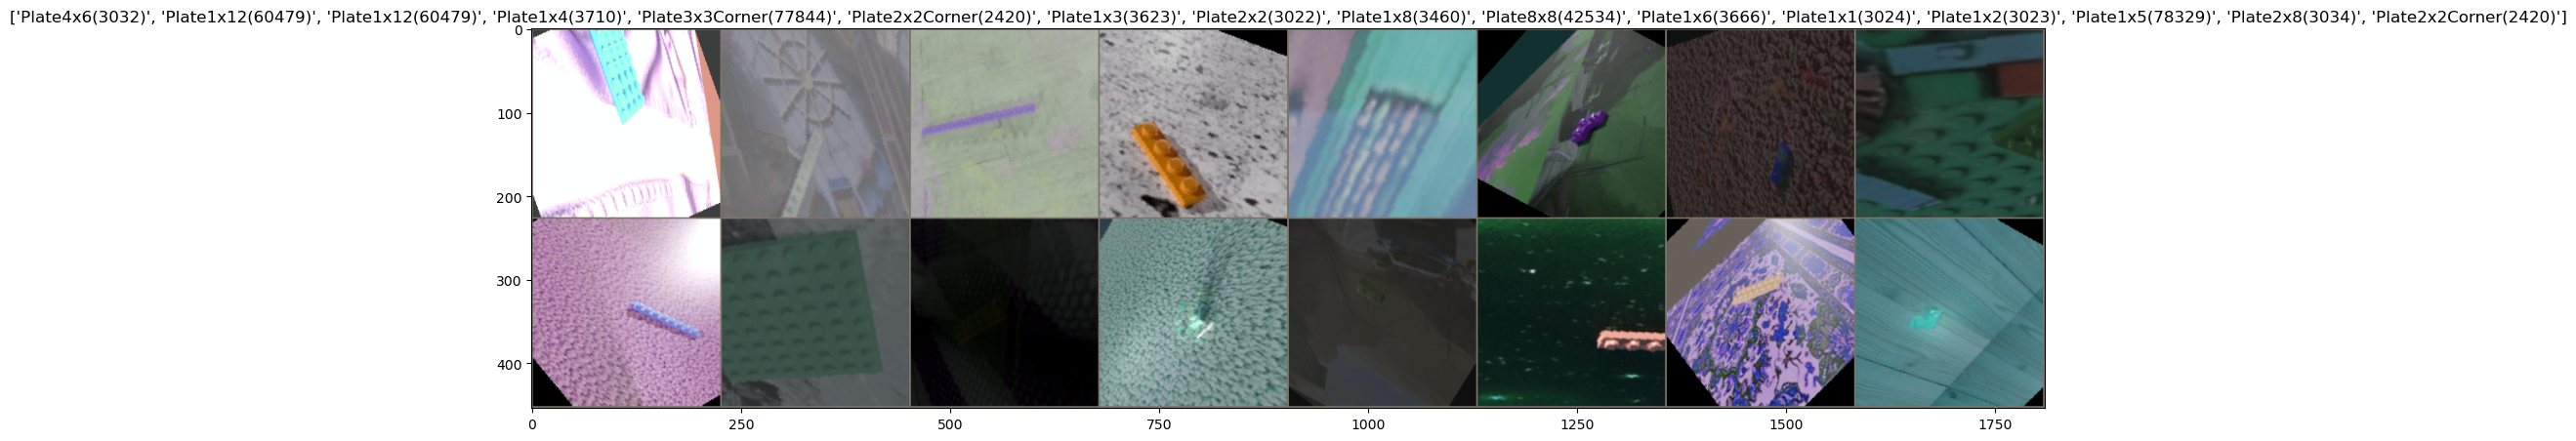

In [14]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # show the image with resolution 224x224
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

wandb.log({"examples": [wandb.Image(out)]})

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_acc = 0.0

    with TemporaryDirectory() as tempdir:
        model_dir = os.path.join(tempdir, 'model')
        torch.save(model.state_dict(), model_dir)

        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader = train_loader
                else:
                    model.eval()
                    dataloader = val_loader

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                loop = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
                for batch, (inputs, labels) in loop:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    loop.set_description(f'Epoch [{epoch + 1}/{num_epochs}]')
                    loop.set_postfix(loss=running_loss / len(dataloader.dataset), acc=running_corrects.double() / len(dataloader.dataset))

                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = running_corrects.double() / len(dataloader.dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                wandb.log({f'{phase}_loss': epoch_loss, f'{phase}_acc': epoch_acc}, step=epoch)

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), model_dir)

                if phase == 'train':
                    scheduler.step()

            print()
            
        model.load_state_dict(torch.load(model_dir))

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    return model


In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

acc,▁▅▄█
loss,█▅▅▁
acc,0.23061
loss,2.56047


Epoch 0/24
----------


train Loss: 2.5414 Acc: 0.2358


val Loss: 2.3809 Acc: 0.2746

Epoch 1/24
----------


train Loss: 2.4188 Acc: 0.2609


val Loss: 2.2989 Acc: 0.2977

Epoch 2/24
----------


train Loss: 2.3259 Acc: 0.2929


val Loss: 2.1516 Acc: 0.3344

Epoch 3/24
----------


train Loss: 2.2612 Acc: 0.3071


val Loss: 2.1856 Acc: 0.3229

Epoch 4/24
----------


train Loss: 2.2606 Acc: 0.3037


val Loss: 2.1717 Acc: 0.3008

Epoch 5/24
----------


train Loss: 2.2586 Acc: 0.3239


val Loss: 2.1071 Acc: 0.3428

Epoch 6/24
----------


train Loss: 2.2292 Acc: 0.3184


val Loss: 2.0996 Acc: 0.3564

Epoch 7/24
----------


train Loss: 2.2047 Acc: 0.3231


val Loss: 2.0601 Acc: 0.3742

Epoch 8/24
----------


train Loss: 2.2298 Acc: 0.3160


val Loss: 2.0937 Acc: 0.3522

Epoch 9/24
----------


train Loss: 2.2134 Acc: 0.3163


val Loss: 2.1103 Acc: 0.3669

Epoch 10/24
----------


train Loss: 2.2076 Acc: 0.3163


val Loss: 2.1088 Acc: 0.3438

Epoch 11/24
----------


train Loss: 2.2256 Acc: 0.3265


val Loss: 2.0753 Acc: 0.3595

Epoch 12/24
----------


train Loss: 2.2129 Acc: 0.3226


val Loss: 2.1029 Acc: 0.3585

Epoch 13/24
----------


train Loss: 2.2012 Acc: 0.3255


val Loss: 2.0967 Acc: 0.3658

Epoch 14/24
----------


train Loss: 2.2080 Acc: 0.3218


val Loss: 2.1039 Acc: 0.3616

Epoch 15/24
----------


train Loss: 2.2145 Acc: 0.3168


val Loss: 2.0881 Acc: 0.3532

Epoch 16/24
----------


train Loss: 2.2038 Acc: 0.3160


val Loss: 2.1363 Acc: 0.3302

Epoch 17/24
----------


train Loss: 2.2133 Acc: 0.3134


val Loss: 2.1067 Acc: 0.3532

Epoch 18/24
----------


train Loss: 2.2093 Acc: 0.3173


val Loss: 2.0967 Acc: 0.3375

Epoch 19/24
----------


train Loss: 2.1990 Acc: 0.3420


val Loss: 2.0722 Acc: 0.3627

Epoch 20/24
----------


train Loss: 2.2234 Acc: 0.3160


val Loss: 2.0828 Acc: 0.3512

Epoch 21/24
----------


train Loss: 2.2313 Acc: 0.3205


val Loss: 2.1010 Acc: 0.3543

Epoch 22/24
----------


train Loss: 2.2228 Acc: 0.3228


val Loss: 2.1275 Acc: 0.3302

Epoch 23/24
----------


train Loss: 2.1954 Acc: 0.3289


val Loss: 2.1161 Acc: 0.3354

Epoch 24/24
----------


train Loss: 2.2105 Acc: 0.3304


val Loss: 2.0830 Acc: 0.3595

Training complete in 28m 32s
Best val Acc: 0.374214


C:\Users\Elliott\AppData\Local\Temp\ipykernel_12868\3294141587.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_dir))


In [17]:
# save the model
model_name = 'Nov12.pth'
torch.save(model, model_name)

In [ ]:
# save the model to wandb
wandb.save(model_name)

OSError: [WinError 1314] A required privilege is not held by the client: 'c:\\Users\\Elliott\\3D Objects\\Code\\legoproject\\Nov12.pth' -> 'c:\\Users\\Elliott\\3D Objects\\Code\\legoproject\\wandb\\run-20241113_020218-tb3mnnxg\\files\\Nov12.pth'

: 

In [13]:
# test the model
model.eval()
correct = 0
total = 0
my_table = wandb.Table(columns=["image", "true", "pred"])
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            my_table.add_data(wandb.Image(images[i], caption=f"true: {class_names[labels[i]]}, pred: {class_names[predicted[i]]}"), class_names[labels[i]], class_names[predicted[i]])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
wandb.log({"test_acc": correct / total})
wandb.log({"test_table": my_table})